In [ ]:
import os

data_dir = "data" 
clases = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(clases)


In [121]:
import tensorflow as tf
import numpy as np

IMAGE_SIZE = 100

# Cargar el dataset desde la carpeta 'data'
train_ds = tf.keras.utils.image_dataset_from_directory(
    "data",                     # Carpeta raíz con subcarpetas por clase
    image_size=(IMAGE_SIZE, IMAGE_SIZE),      # Redimensionar todas las imágenes
    batch_size=1,              # Tamaño del lote
    color_mode='grayscale',     # Convertir a escala de grises
    shuffle=True                # Mezclar las imágenes
)

class_names = train_ds.class_names  # guárdalo aquí

train_ds = train_ds.unbatch()


Found 2527 files belonging to 6 classes.


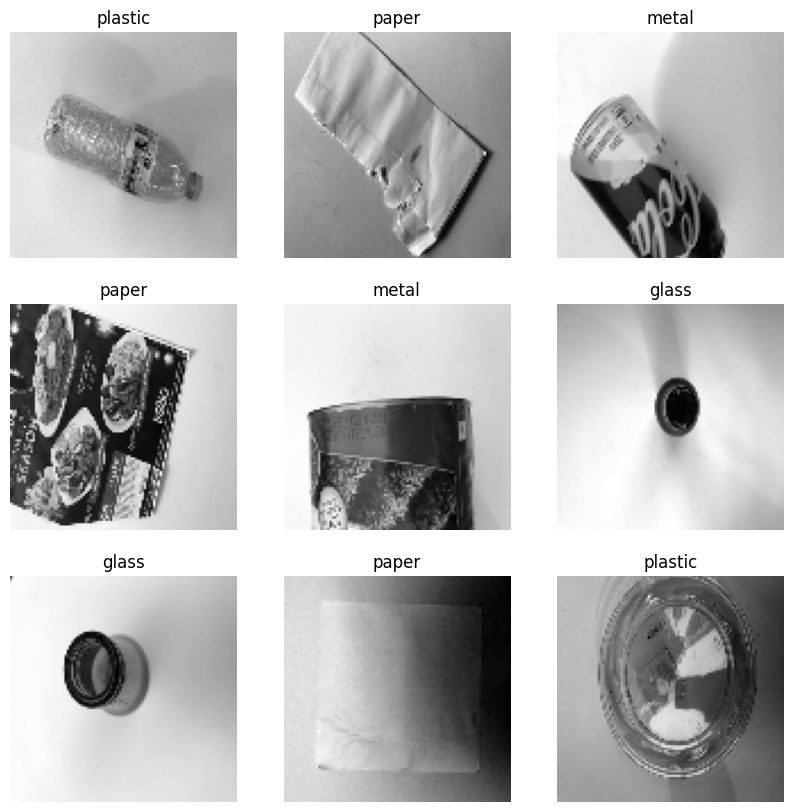

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8").squeeze(), cmap='gray')  # quitar canal extra y usar escala de grises
    plt.title(class_names[label.numpy()])
    plt.axis("off")

plt.show()


In [123]:
data_train = []

for image, label in train_ds:
    # Convertimos la imagen a NumPy con tipo uint8
    image_np = image.numpy().astype(np.uint8)
    # Aseguramos la forma (H, W, 1)
    if image_np.ndim == 2:
        image_np = np.expand_dims(image_np, axis=-1)
    
    # Guardamos como [imagen, label]
    data_train.append([image_np, label])


In [ ]:
len(data_train)

In [124]:
images_list = [] #Imagenes de entrada
labels_list = [] #Etiquetas

for image, label in data_train:
    images_list.append(image)
    labels_list.append(label)

In [125]:
images_list = np.array(images_list).astype(float) / 255

In [126]:
labels_list = np.array(labels_list)

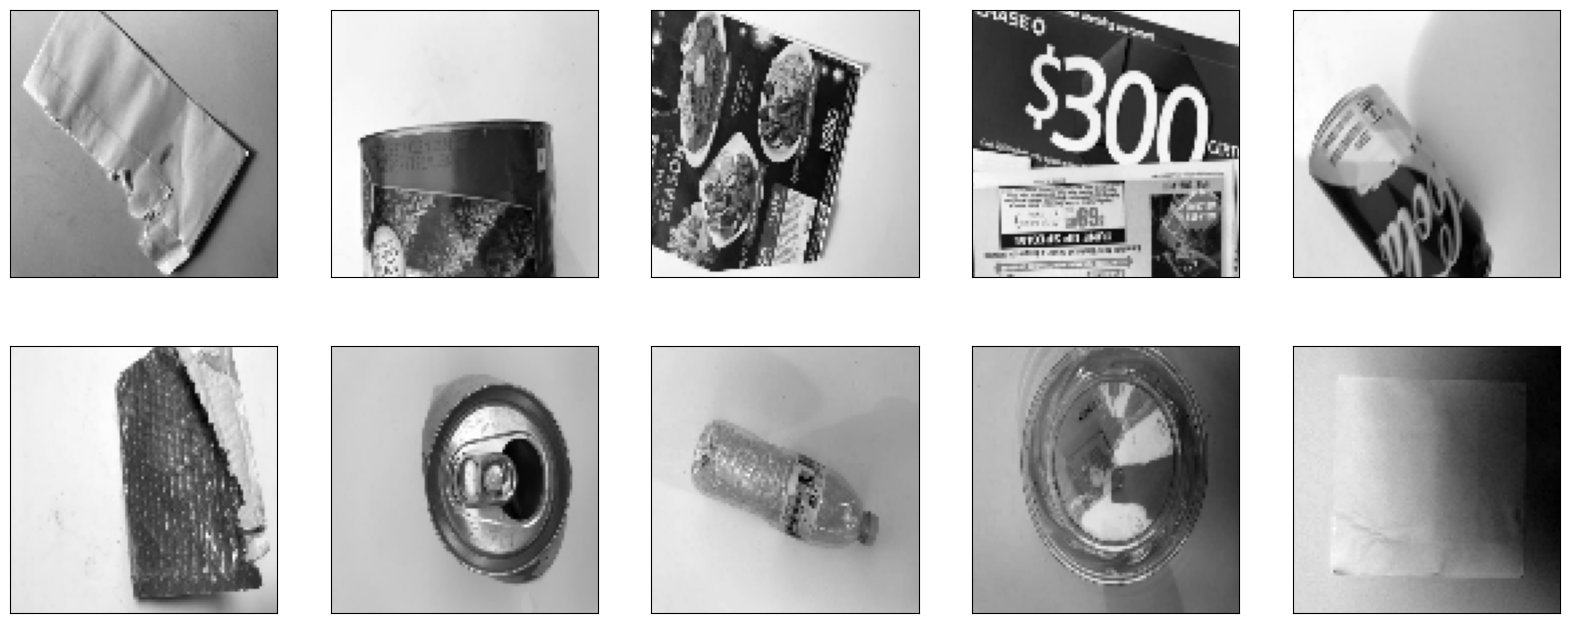

In [127]:
#ver las imagenes de la variable X sin modificaciones por aumento de datos
plt.figure(figsize=(20, 8))

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(images_list[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")

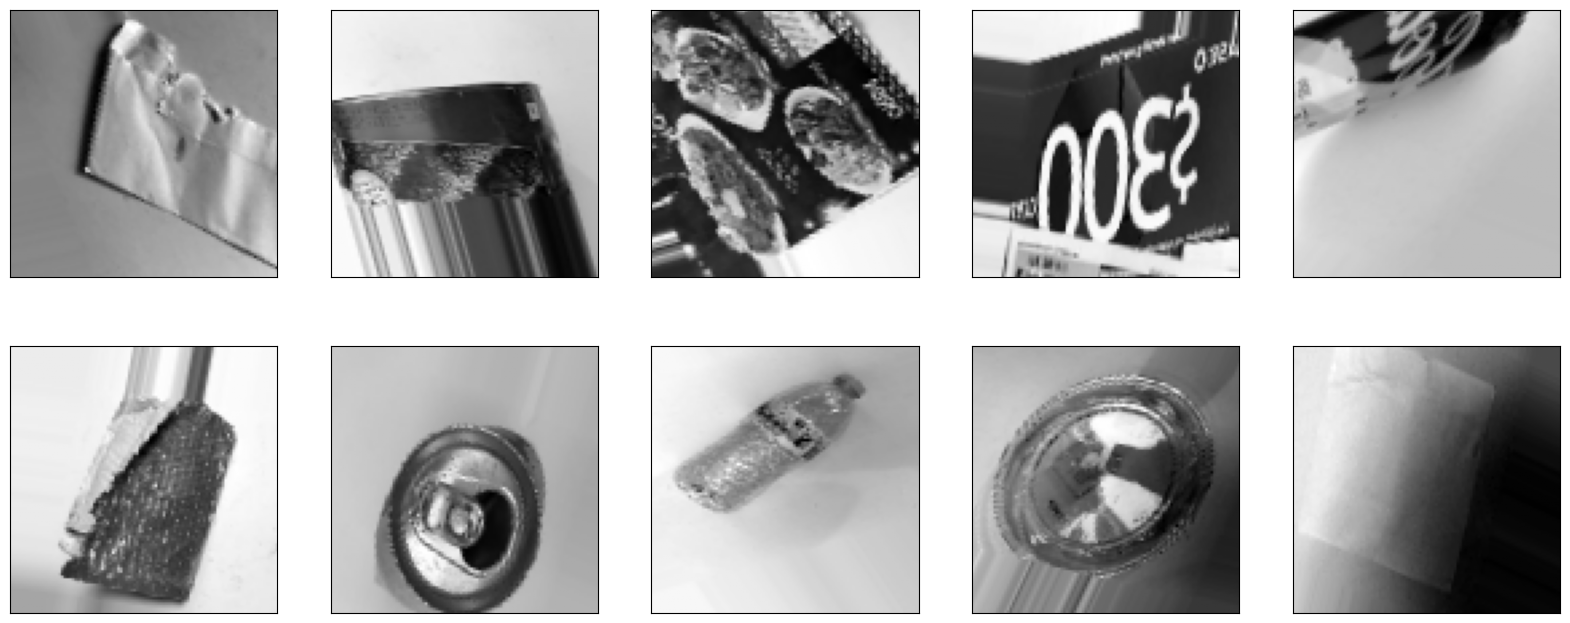

In [128]:
#Realizar el aumento de datos con varias transformaciones. Al final, graficar 10 como ejemplo
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=15,
    zoom_range=[0.7, 1.4],
    horizontal_flip=True,
    vertical_flip=True,
    # brightness_range=[0.8, 1.2],
    fill_mode='nearest',
)

datagen.fit(images_list)

plt.figure(figsize=(20,8))

for image, label in datagen.flow(images_list, labels_list, batch_size=10, shuffle=False):
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
  break

In [129]:
len(images_list) - (len(images_list) * .85) #19700

379.0500000000002

In [130]:
len(images_list) * .85 #2147
len(images_list) - 2147 #379

images_train = images_list[:2147]
images_validation = images_list[2147:]

labels_train = labels_list[:2147]
labels_validation = labels_list[2147:]

In [ ]:
data_gen_train = datagen.flow(images_train, labels_train, batch_size=32)

In [132]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
#Cargar la extension de tensorboard de colab
%load_ext tensorboard

In [133]:
tensorboard = TensorBoard(log_dir='logs/one')

In [134]:
#Ejecutar tensorboard e indicarle que lea la carpeta "logs"
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 26862), started 0:14:45 ago. (Use '!kill 26862' to kill it.)

In [135]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax') 
])

/Users/carlosaraujo/Code/garbage-classification/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [136]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # o categorical si tienes one-hot
    metrics=['accuracy']
)


In [137]:
#Usar la funcion flow del generador para crear un iterador que podamos enviar como entrenamiento a la funcion FIT del modelo
model.fit(
    data_gen_train,
    epochs=150, batch_size=32,
    validation_data=(images_validation, labels_validation),
    steps_per_epoch=len(images_train) // 32,
    verbose=1,
    callbacks=[tensorboard]
)

/Users/carlosaraujo/Code/garbage-classification/venv/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.2681 - loss: 1.6729 - val_accuracy: 0.3211 - val_loss: 1.6516
Epoch 2/150
 1/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5000 - loss: 1.5079

/Users/carlosaraujo/Code/garbage-classification/venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 1.5079 - val_accuracy: 0.2921 - val_loss: 1.7622
Epoch 3/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3253 - loss: 1.6075 - val_accuracy: 0.3263 - val_loss: 1.6452
Epoch 4/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3125 - loss: 1.3852 - val_accuracy: 0.3237 - val_loss: 1.7009
Epoch 5/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.3319 - loss: 1.5683 - val_accuracy: 0.3632 - val_loss: 1.5825
Epoch 6/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.6052 - val_accuracy: 0.3763 - val_loss: 1.5845
Epoch 7/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.3749 - loss: 1.5262 - val_accuracy: 0.3579 - val_loss: 1.5690
Epoch 8/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4688 - loss: 1.4426 - val_accuracy: 0.3605 - val_loss: 1.5623
Epoch 9/150
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.3910 - loss: 1.4908 - val_accuracy: 0.3289 - val_loss:

In [138]:
loss, accuracy = model.evaluate(images_validation, labels_validation, verbose=1)
print(f"Pérdida: {loss:.4f}")
print(f"Precisión: {accuracy:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6684 - loss: 0.8703
Pérdida: 0.8703
Precisión: 0.6684


In [140]:
import cv2

# Cargar y preprocesar la imagen
img_path = "test_images/image-1.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = img / 255.0
img = np.expand_dims(img, axis=(0, -1))  # (1, H, W, 1)

# Predecir
pred = model.predict(img)
label_pred = np.argmax(pred)

print("Clase predicha:", class_names[label_pred])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Clase predicha: metal


In [141]:
model.save('garbage-classification-cnn-ad.h5')

In [149]:
%pip install tensorflowjs


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [143]:
%mkdir output_folder

In [150]:
%tensorflowjs_converter --input_format keras garbage-classification-css-ad.h5 output_folder/

UsageError: Line magic function `%tensorflowjs_converter` not found.
